## Stock Return Prediction

In this case study we will use various supervised learning-based models to predict the stock price of PRT using correlated assets and its own historical data.

## Content

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, weekly return of the
PRT stock is the predicted variable. We need to understand what affects RPRT stock price and hence incorporate as much information into the model. 

For this case study, other than the historical data of PRT, the independent variables used are the following potentially correlated assets:
* Stocks: COSL SEO
* Currency: 没有用上汇率
* Indices: CES280

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [57]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor


from tensorflow import keras
#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf



In [58]:
#Diable the warnings``c
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Loading the Data

    Next, we extract the data required for our analysis using pandas datareader. 

我们选定的股票是：

    ① PRT 中国石油股份有限公司，股票代码为00857。

其相关的公司及股票代码有：

    ② COSL 海油田服务股份有限公司务，股票代码为02883。

    ③ SEO 中海石油（中国）有限公司，股票代码为00883。

④ YCIH 延长石油国际工程技术服务（香港）有限公司，股票代码为00363。

⑤ SNP 中石化国际化工有限公司，股票代码为00386。

⑥ SHI 中石化冠德控股有限公司，股票代码为00934。

我们选定的指数是：

我们选择和油气生产商相关的指数，它们分别是：

① CES120，其中包括中国石油股份有限公司（00857）、中国海洋石油有限公司（00883）和中海油田服务股份有限公司（02883）等油气生产商。

    ② CES280，其中包括中国石油股份有限公司（00857）、中国海洋石油有限公司（00883）等油气生产商。

③ HKL和 ④ HSI，其中包括中国石油股份有限公司（00857）、中国海洋石油有限公司（00883）等油气生产商。 


指数：

CES100、CES120、CES280、CES300、CESA80、CESG10、CESM是中华交易服务有限公司（CESC）开发的跨境指数，用于反映中国内地和香港市场的股票价格变动。

GEM是香港联合交易所创业板指数，用于反映创业板上市公司的表现。

HKL是恒生综合大型股指数，用于反映恒生综合指数中大型股的表现。

HSI是恒生指数，用于反映香港主板上市公司的表现。

In [70]:

# 表头
head_name = ['date', 'open', 'high', 'low', 'close', 'volumn', 'amount']

# 这是指数|
idx_names = ['HSI', 'HKL', 'CES120', 'CES280']
idx_1 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\\indx\\HSI.csv", names= head_name)
idx_2 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\\indx\\HKL.csv", names= head_name)
idx_3 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\\indx\\CES120.csv", names= head_name)
idx_4 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\\indx\\CES280.csv", names= head_name)

# 这里是加载股票数据
stk_names = ['PRT', 'COSL', 'SEO', 'YCIH', 'SNP', 'SHI']

stk_1 = pd.read_csv("D:\\Documents\MLProject\\fin-ml\stock\\00857.csv", names= head_name)
stk_2 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\\stock\\02883.csv", names= head_name)
stk_3 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\stock\\00883.csv", names= head_name)
stk_4 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\\stock\\00363.csv", names= head_name)
stk_5 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\\stock\\00386.csv", names= head_name)
stk_6 = pd.read_csv("D:\\Documents\\MLProject\\fin-ml\stock\\00934.csv", names= head_name)

Next, we need a series to predict. We choose to predict using weekly returns. We approximate this by using 5 business day period returns.

    Q1 滞后5天回报率是什么呢？ 

就是把因变量的t-5时间作为自变量计算出来的回报率

    Q2 为什么指数不用往前移？
在使用线性回归模型时，可能需要向前移动return_period来消除滞后效应或季节性因素。在计算指数时，并不需要向前移动return_period，因为指数本身就是一个相对值，它反映了基期与报告期之间的价格变化比率。如果向前移动return_period，则会打乱这种比率关系，并且会导致数据缺失。

In [71]:
return_period = 5

In [84]:
#PRT的历史回报率

# 用numpy库的log函数对stk_1数据框中的PRT股票的收盘价取自然对数，然后计算每个return_period间隔的对数收益率，最后将结果向前移动return_period个位置。
Y1 = np.log(stk_1.loc[:, ('close')]).diff(return_period).shift(-return_period)

# 这个代码是在用Python的pandas库来合并两个数据框（dataframe）。
# 具体来说，它是把stk_1这个数据框中的’date’列和Y1这个数据框按照列的方向（axis=‘columns’）拼接起来，然后赋值给Y。这样Y就是一个包含了日期和其他信息的新的数据框。
Y = pd.concat([stk_1['date'], Y1], axis='columns')

# 这个代码是在用Python的pandas库来修改数据框Y的列名（columns）。
# 具体来说，它是把原来的列名（‘date’, ‘open’, ‘high’, ‘low’, ‘close’, ‘volume’）改成了新的列名（‘date’, ‘PRT_pred’）。这样Y就是一个只包含了日期和PRT_pred两列的新的数据框。
Y.columns = ['date', 'PRT_pred']


# 相关资产的历史回报率
X1 = np.log(stk_2.loc[:, ('close')]).diff(return_period).shift(-return_period)
X1 = pd.concat([stk_2['date'], X1], axis='columns')
X1.columns = ['date', stk_names[1]]

X2 = np.log(stk_3.loc[:, ('close')]).diff(return_period).shift(-return_period)
X2 = pd.concat([stk_3['date'], X2], axis='columns')
X2.columns = ['date', stk_names[2]]

X3 = np.log(stk_4.loc[:, ('close')]).diff(return_period).shift(-return_period)
X3 = pd.concat([stk_4['date'], X3], axis='columns')
X3.columns = ['date', stk_names[3]]

X4 = np.log(stk_5.loc[:, ('close')]).diff(return_period).shift(-return_period)
X4 = pd.concat([stk_5['date'], X4], axis='columns')
X4.columns = ['date', stk_names[4]]

X5 = np.log(stk_6 .loc[:, ('close')]).diff(return_period).shift(-return_period)
X5 = pd.concat([stk_6['date'], X5], axis='columns')
X5.columns = ['date', stk_names[5]]

# 指数 
X6 = np.log(idx_1.loc[:, ('close')]).diff(return_period)
X6 = pd.concat([idx_1['date'], X6], axis='columns')
X6.columns = ['date', idx_names[0]]

X7 = np.log(idx_2.loc[:, ('close')]).diff(return_period)
X7 = pd.concat([idx_2['date'], X7], axis='columns')
X7.columns = ['date', idx_names[1]]

X8 = np.log(idx_3.loc[:, ('close')]).diff(return_period)
X8 = pd.concat([idx_3['date'], X8], axis='columns')
X8.columns = ['date', idx_names[2]]

X9 = np.log(idx_4.loc[:, ('close')]).diff(return_period)
X9 = pd.concat([idx_4['date'], X9], axis='columns')
X9.columns = ['date', idx_names[3]]

idx_X = pd.merge(X6, X7, on='date', how='left')
idx_X = pd.merge(idx_X, X8, on='date', how='left')
idx_X = pd.merge(idx_X, X9, on='date', how='left')


# PRT-15、 PRT-30、 PRT-60 
X10 = np.log(stk_1.loc[:, ('close')]).shift(-return_period*3)
X11 = np.log(stk_1.loc[:, ('close')]).shift(-return_period*6)
X12 = np.log(stk_1.loc[:, ('close')]).shift(-return_period*12)
lagged_X = pd.concat([stk_1['date'], X10, X11, X12], axis='columns')
lagged_X.columns = ['date', 'PRT-15', 'PRT-30', 'PRT-60']

X = pd.merge(idx_X, lagged_X, on='date', how='left')
X = pd.merge(X, X1, on='date', how='left')
X = pd.merge(X, X2, on='date', how='left')
X = pd.merge(X, X3, on='date', how='left')
X = pd.merge(X, X4, on='date', how='left')
X = pd.merge(X, X5, on='date', how='left')

dataset = pd.merge(Y, X, on='date', how='left')

# 删除缺失值
dataset = dataset.dropna()


# 从dataset中选取’date’和’PRT_pred’两列，赋值给Y
Y = dataset.loc[:, ['date', 'PRT_pred']]

# 把Y中的’date’列设为索引
Y['date'] = pd.to_datetime(Y['date'])

# 设置data列为索引
Y = Y.set_index('date')

#去掉Y中含有缺失值的行
Y = Y.dropna()


X['date'] = pd.to_datetime(X['date'])
X = X.set_index('date')
X = X.dropna()

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

Lets have a look at the dataset we have

In [85]:
# 设置输出数值的精度
pd.set_option('precision', 3)

# 输出数据集的描述性统计量
dataset.describe()

,PRT_pred,HSI,HKL,CES120,CES280,PRT-15,PRT-30,PRT-60,COSL,SEO,YCIH,SNP,SHI
count,749.000,749.000,749.000,749.000,749.000,749.000,749.000,749.000,749.000,7.490e+02,7.490e+02,7.490e+02,749.000
mean,-0.003,0.001,0.002,0.003,0.002,1.787,1.779,1.763,-0.005,-6.990e-04,-5.908e-04,-9.321e-04,-0.003
std,0.041,0.025,0.025,0.031,0.040,0.217,0.211,0.197,0.061,4.543e-02,4.225e-02,3.815e-02,0.056
min,-0.138,-0.114,-0.119,-0.170,-0.275,1.430,1.430,1.430,-0.229,-1.800e-01,-2.227e-01,-1.355e-01,-0.375
25%,-0.027,-0.014,-0.013,-0.010,-0.011,1.643,1.643,1.643,-0.041,-2.512e-02,-2.333e-02,-2.267e-02,-0.030
50%,-0.006,0.003,0.004,0.004,0.005,1.690,1.690,1.690,-0.008,-1.982e-03,-2.430e-03,0.000e+00,-0.005
75%,0.018,0.016,0.017,0.019,0.020,1.839,1.821,1.803,0.027,2.205e-02,1.989e-02,2.135e-02,0.026
max,0.192,0.111,0.112,0.112,0.108,2.365,2.365,2.365,0.296,2.465e-01,2.265e-01,1.997e-01,0.211


In [86]:
# 返回数据集的前n行，默认为5行
dataset.head()

,date,PRT_pred,HSI,HKL,CES120,CES280,PRT-15,PRT-30,PRT-60,COSL,SEO,YCIH,SNP,SHI
3602,2014/11/19,0.034,-0.024,-0.025,-0.031,-0.011,2.099,2.168,2.161,0.029,0.070,0.044,0.043,0.043
3603,2014/11/20,0.019,-0.028,-0.029,-0.029,-0.009,2.088,2.144,2.164,-0.003,0.044,0.027,0.032,0.052
3604,2014/11/21,-0.034,-0.027,-0.028,-0.020,0.003,2.091,2.148,2.195,-0.096,-0.047,0.011,0.006,-0.081
3605,2014/11/24,-0.112,0.004,0.004,0.021,0.035,2.110,2.172,2.185,-0.156,-0.134,-0.027,-0.065,-0.094
3606,2014/11/25,-0.068,0.013,0.013,0.039,0.049,2.087,2.176,2.176,-0.160,-0.118,-0.027,-0.034,-0.064


<a id='2.2'></a>
## 3.2. Data Visualization

Next, lets look at the distribution of the data over the entire period

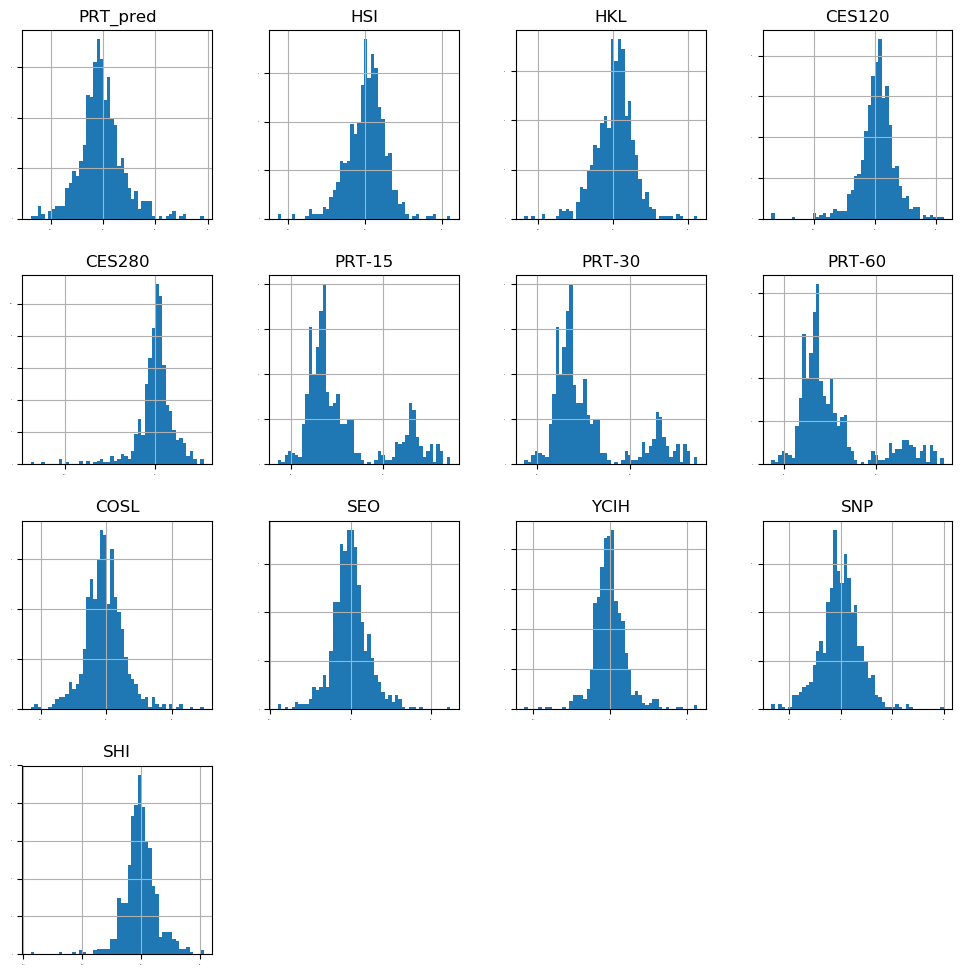

In [87]:
# 直方图 
# bins：指定显示多少个柱子，默认为10。
# sharex：是否共享x轴，默认为False。
# sharey：是否共享y轴，默认为False。
# xlabelsize：指定x轴标签的大小，默认为None。
# ylabelsize：指定y轴标签的大小，默认为None。
# figsize：指定图形的尺寸（以英寸为单位），默认为None。
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The above histogram shows the distribution for each series individually. Next, lets look at the density distribution over the same x axis scale.

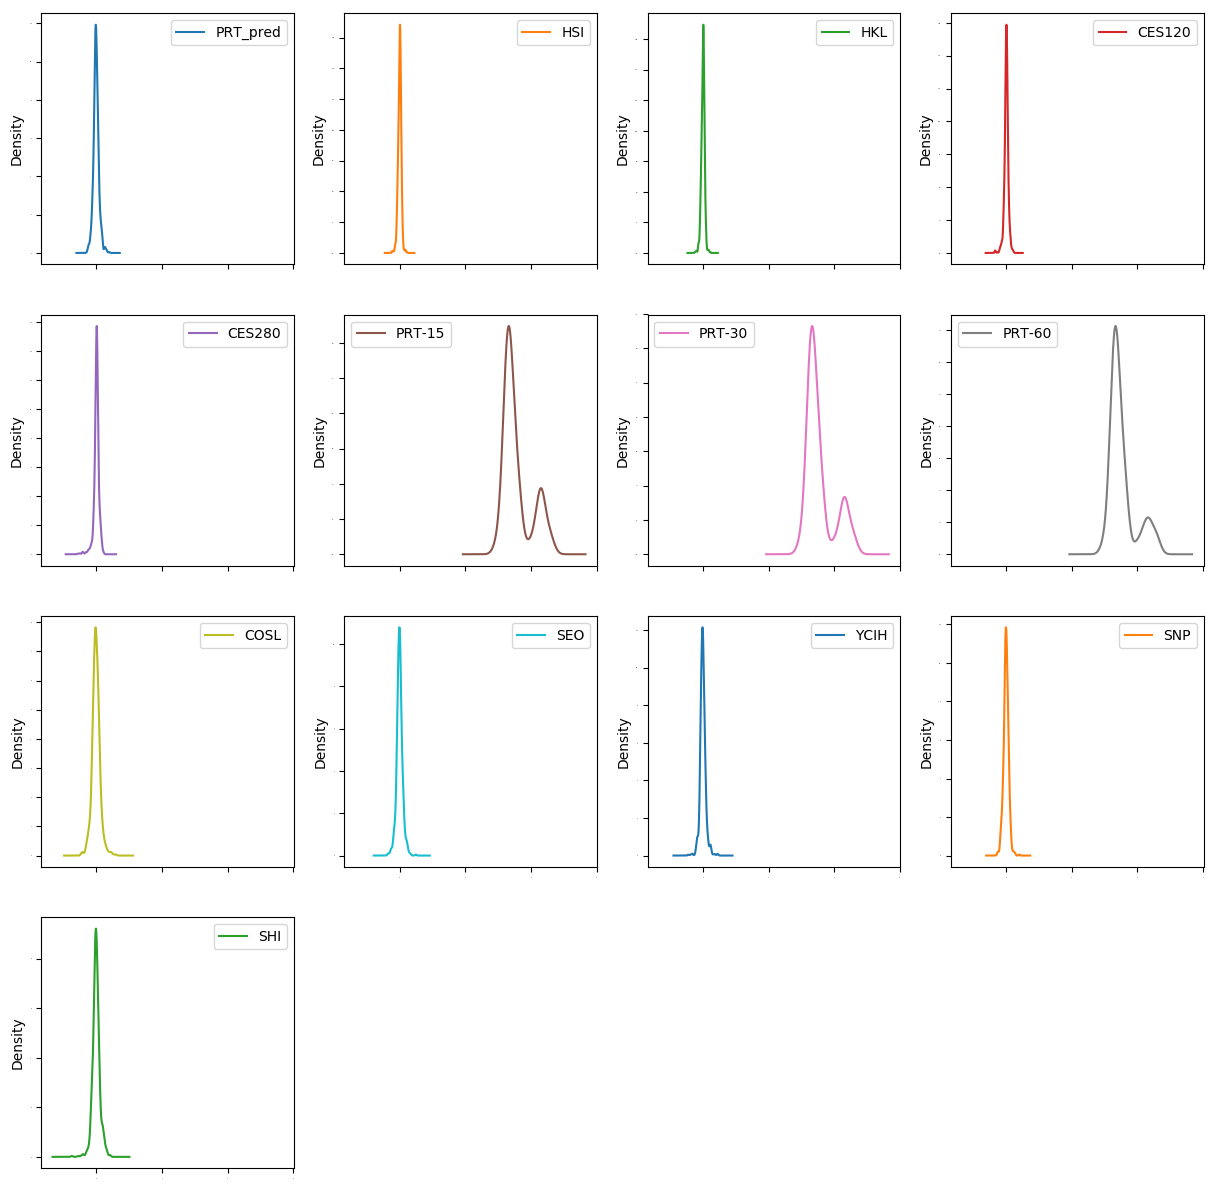

In [82]:
# kind：指定绘制图形的类型，例如’line’表示线图，‘density’表示密度图，默认为’line’。
# subplots：是否将每一列绘制为单独的子图，默认为False。
# layout：指定子图的布局，例如(4,4)表示4行4列，默认为None。
# sharex：是否共享x轴，默认为True。
# sharey：是否共享y轴，默认为False。
# legend：是否显示图例，默认为True。
# fontsize：指定字体大小，默认为None。
# figsize：指定图形的尺寸（以英寸为单位），默认为None

dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

In order to get a sense of the **interdependence** of the data we look at the scatter plot and the correlation matrix

# 相关图怎么看

定义：相关矩阵（correlation matrix）是一种用于表示多个变量之间相关性的矩阵。相关性是一种度量两个变量之间线性关系强度和方向的指标，取值范围在-1到1之间。相关矩阵可以用于分析数据集中各个特征的相互关系，发现潜在的规律或异常值。相关矩阵可以通过计算各对变量之间的皮尔逊相关系数(**此处为皮尔逊相关系数**)来构造，也可以通过协方差矩阵（covariance matrix）进行标准化处理得到。

# 目的：
    发掘数据之间的相关性

#  方法：

线性回归模型的特征选择是指从多个输入变量中选择与输出变量有**最强相关性**或预测能力的一些变量，从而简化模型，提高准确度和解释性。线性回归模型的特征选择有多种方法，其中一些常见的方法如下：

1. 最优子集选择（Best Subset Selection）：这是一种穷举搜索的方法，它尝试所有可能的特征组合，并根据某个评价标准（如R方、AIC、BIC等）选择最优的子集。

2. 逐步回归（Stepwise Selection）：这是一种贪心搜索的方法，它从一个空集或全集开始，每次增加或删除一个特征，并根据某个评价标准（如p值、AIC、BIC等）判断是否继续或停止2。逐步回归有向前、向后和双向三种方式。

3. Lasso回归（Lasso Regression）：这是一种基于正则化的方法，它在最小二乘法的基础上加入了L1范数作为惩罚项，从而使得不重要的特征系数收缩到零，实现了特征选择。

根据给出的图，可以使用相关矩阵来初步筛选出与输出变量有**较高相关性（正或负）的输入变量**。然后你可以使用上述方法之一来进一步优化你的特征子集，并用**交叉验证法**来验证你选出来的特征子集对模型效果是否有提升。

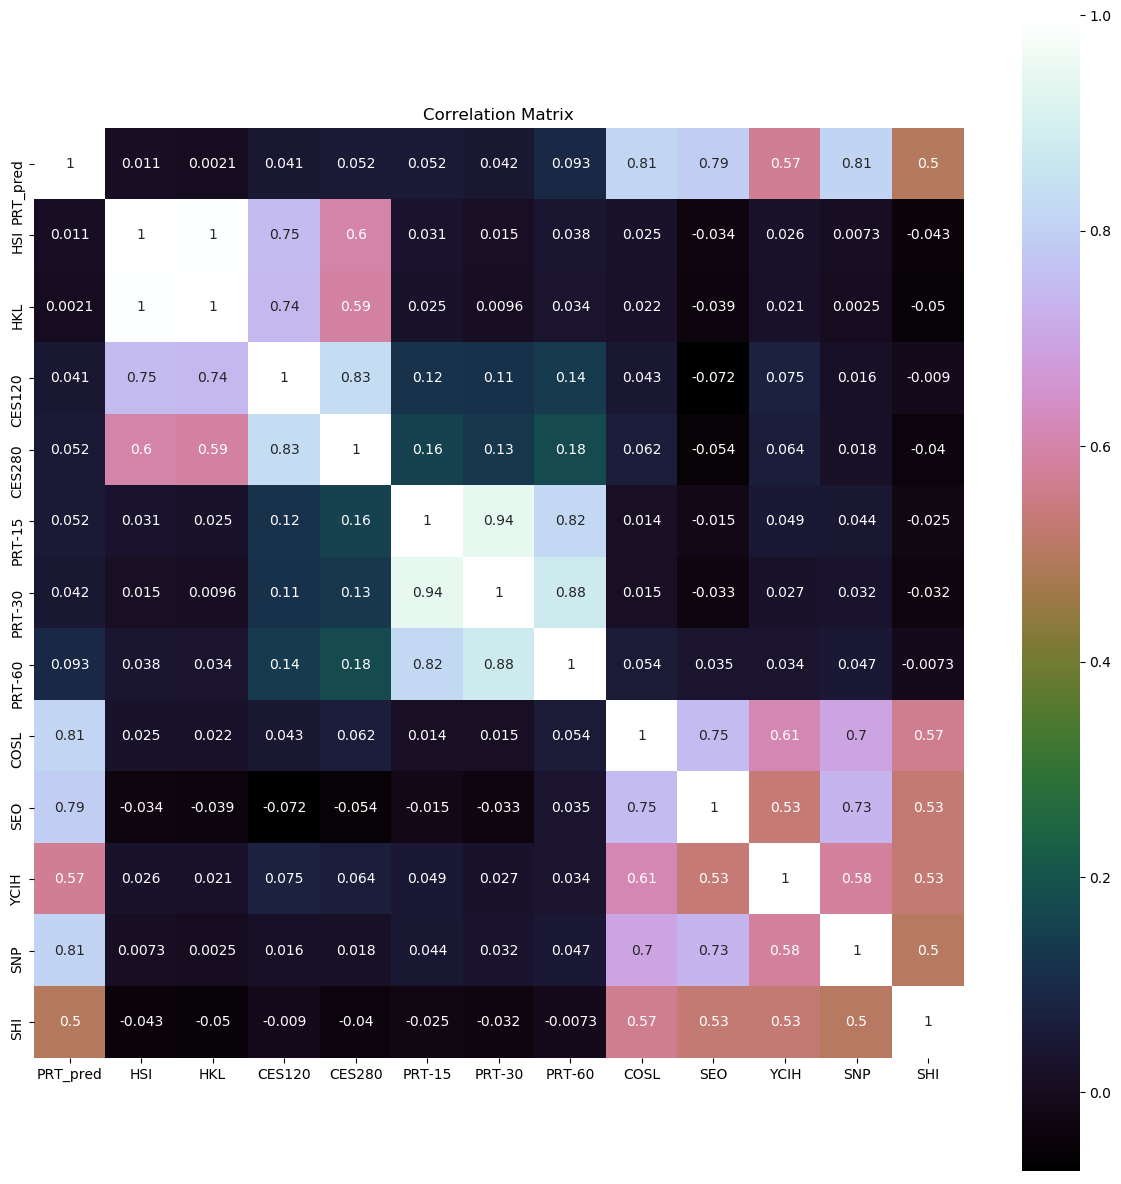

In [88]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

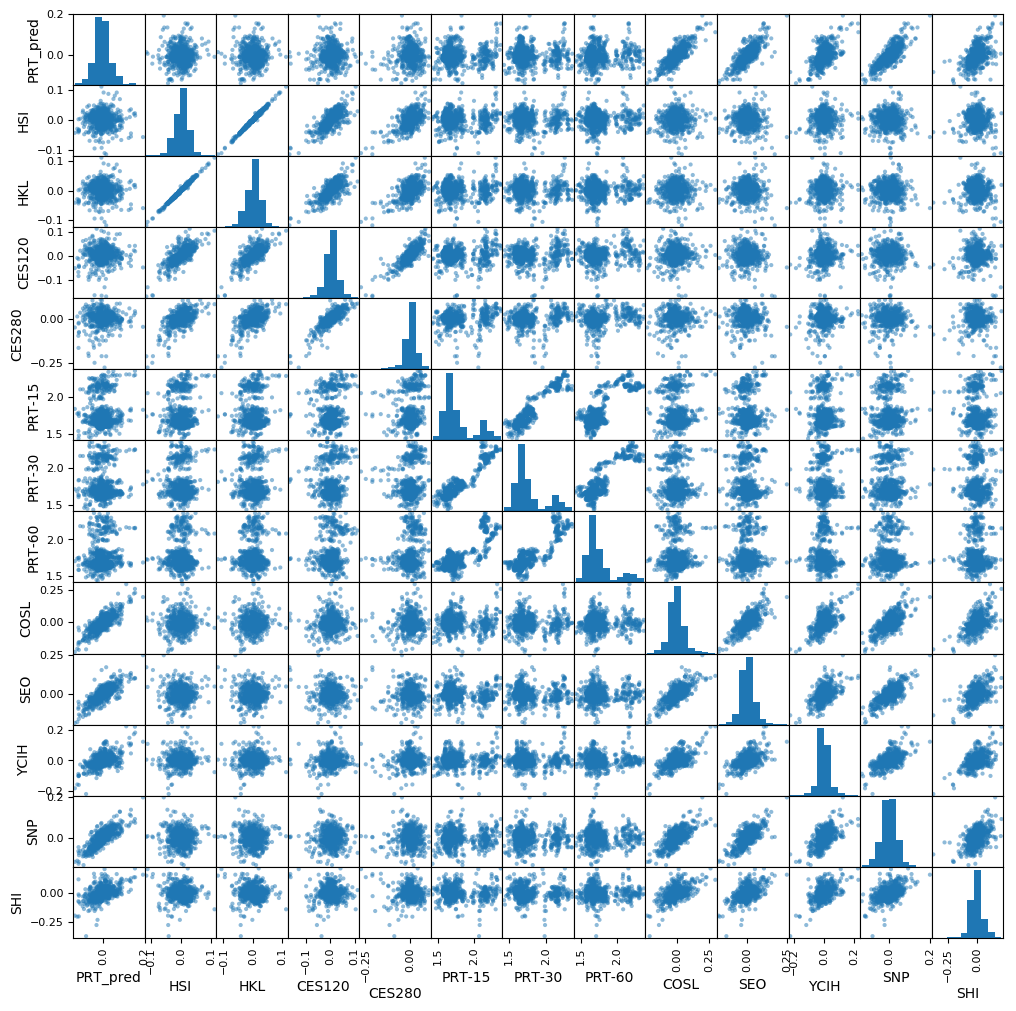

In [11]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

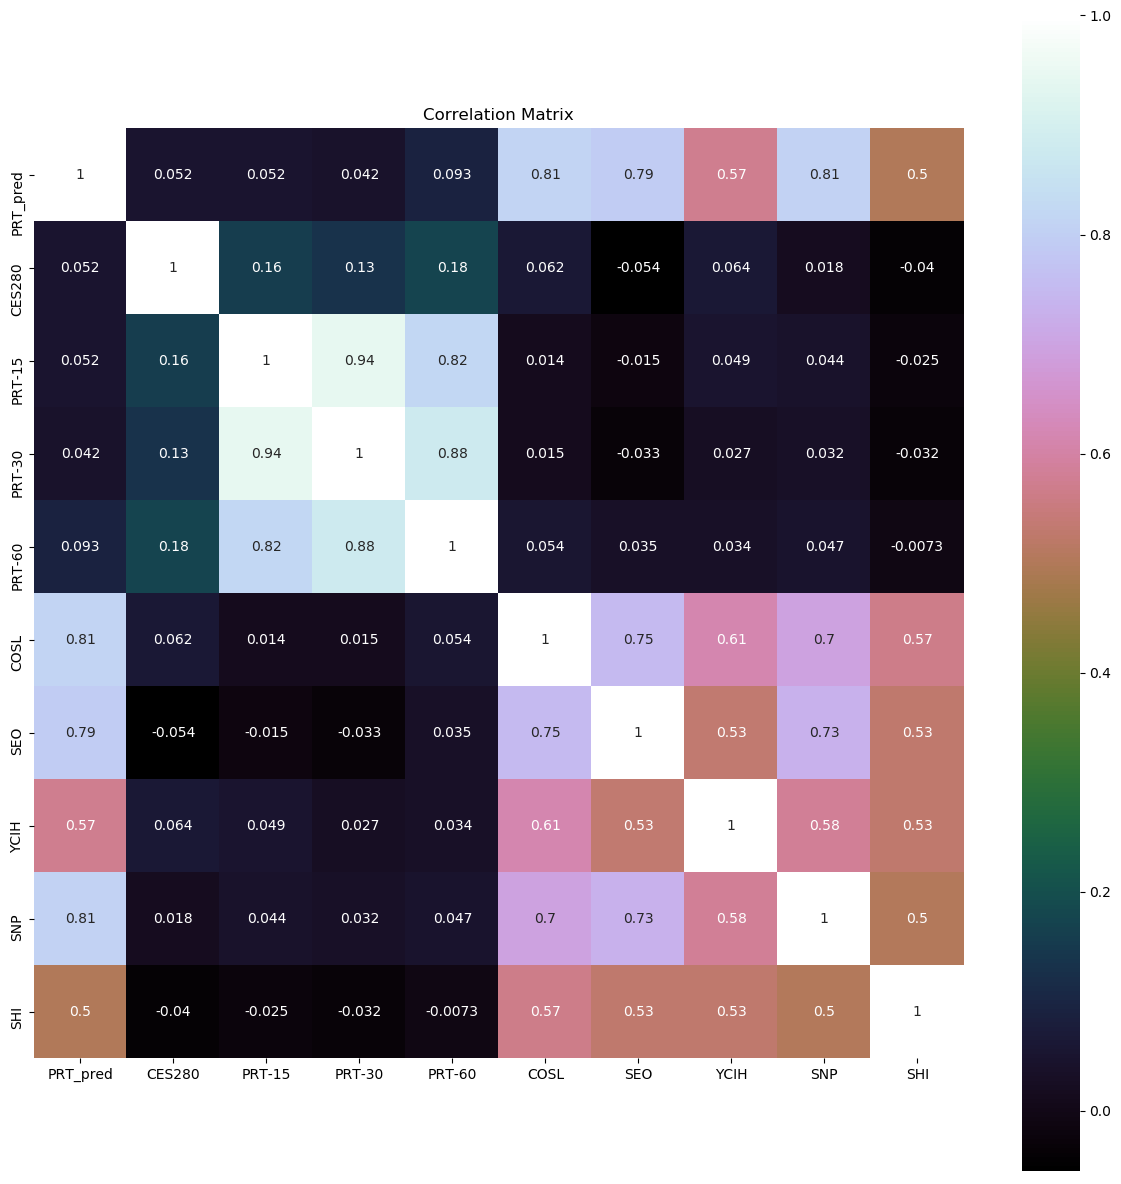

In [12]:
dataset=dataset.drop(columns=['CES120','HSI', 'HKL'])
X = X.drop(columns=['CES120','HSI', 'HKL'])
# show the Correlation Matrix again
# Compute pairwise correlation of columns, excluding NA/null values
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the scatter plot above, we see some linear relationship of the predicted
variable the lagged 15 days, 30 days and 60 days return of PRT.

<a id='2.3'></a>
## 3.3. Time Series Analysis 

Next, we look at the seasonal decomposition of our time series

这段代码出现ValueError: math domain error的可能原因是，Y中有负数或零值，导致在计算对数时出现错误2。要解决这个问题，可以检查Y中是否有非正数，并尝试将它们替换或删除。// 可我已经删除了呀？

尝试使用别的函数：pip install --upgrade statsmodels 

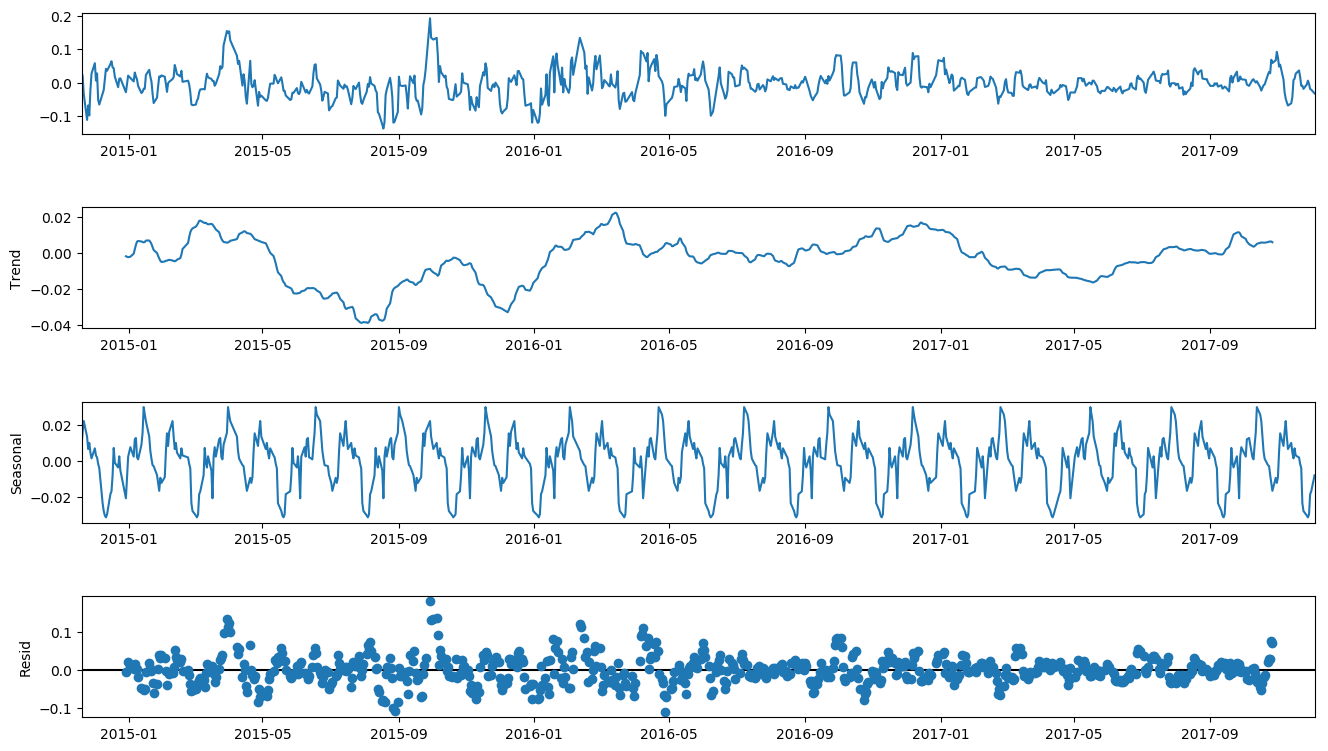

In [13]:
res = sm.tsa.seasonal_decompose(Y, model='additive', period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

We can see that for PRT there has been a general trend upwards. This should show up in our the constant/bias terms in our models

<a id='3'></a>
## 4. Data Preparation

<a id='3.2'></a>
## 4.2. Feature Selection

We use sklearn's SelectKBest function to get a sense of feature importance. 

In [14]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
COSL,1445.717
SNP,1412.597
SEO,1244.802
YCIH,363.471
SHI,250.026
PRT-60,6.553
CES280,2.047
PRT-15,1.994
PRT-30,1.339


We see that COSL seems to be the most important feature and vix being the least important.
drop the CES120 feature

In [15]:
dataset=dataset.drop(columns=['SEO', 'YCIH', 'SHI' ])
X = X.drop(columns=['SEO', 'YCIH', 'SHI' ])

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and Evaluation Metrics

Next, we start by splitting our data in training and testing chunks. If we are going to use Time series models we have to split the data in continous series.

80%的数据集用于建模 ，使用20%用于测试。

In [16]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
# seed = 7
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [17]:
num_folds = 10
seed = 7
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1 Machine Learning models-from scikit-learn

##### Regression and Tree Regression algorithms

In [18]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

##### Neural Network algorithms

In [19]:
models.append(('MLP', MLPRegressor()))

##### Ensable Models

In [20]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First we run the K-fold analysis. Next we run the model on the entire training and testing dataset.

In [21]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.000466 (0.000243) 0.000423 0.000206
LASSO: 0.002002 (0.001170) 0.001971 0.000654
EN: 0.002002 (0.001170) 0.001971 0.000654
KNN: 0.001077 (0.000680) 0.000300 0.000336
CART: 0.001031 (0.000394) 0.000000 0.000691
SVR: 0.001383 (0.000881) 0.001285 0.000453
MLP: 0.000862 (0.000475) 0.000630 0.000199
ABR: 0.000621 (0.000321) 0.000412 0.000248
GBR: 0.000693 (0.000554) 0.000181 0.000236
RFR: 0.000549 (0.000284) 0.000058 0.000285
ETR: 0.000564 (0.000283) 0.000000 0.000227


#### K Fold results

We being by looking at the K Fold results

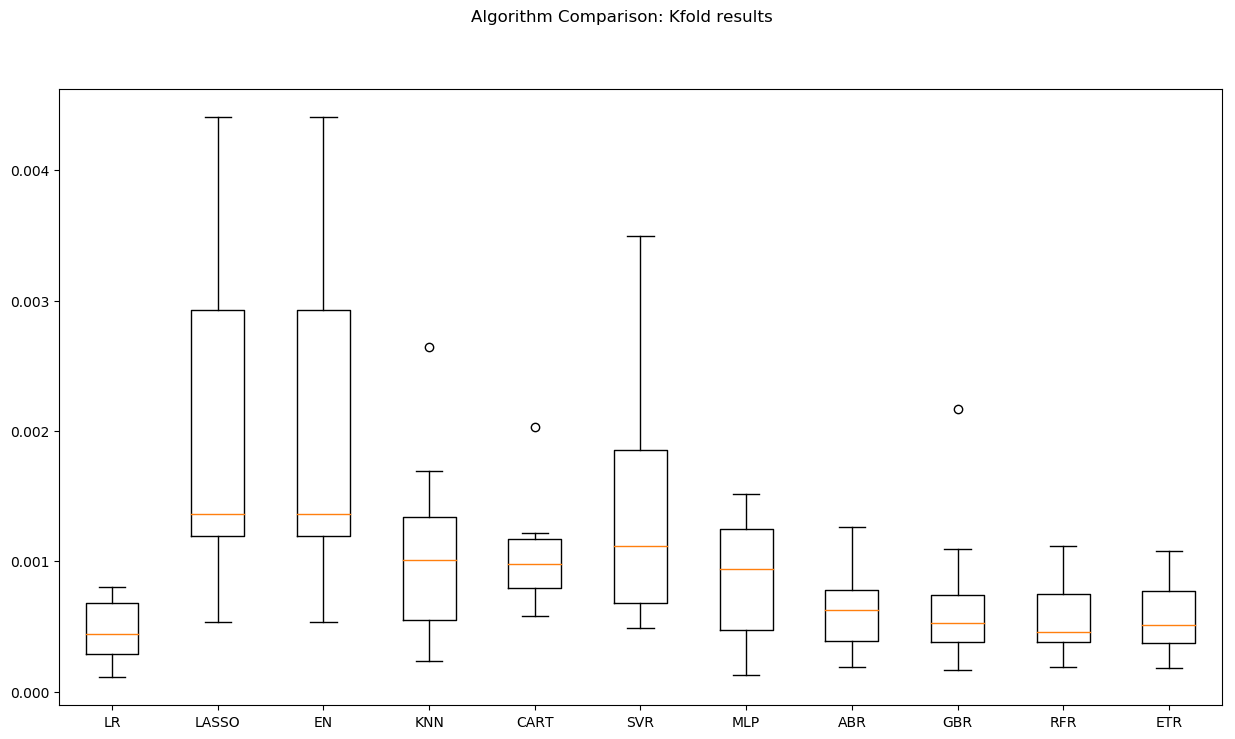

In [22]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

箱线图可以显示每个算法的中位数、四分位数、最大值、最小值和异常值。你可以根据箱线图看出哪个算法的平均性能更好，哪个算法的稳定性更高。

这里看起来就是LR算法最好。

#### Training and Test error

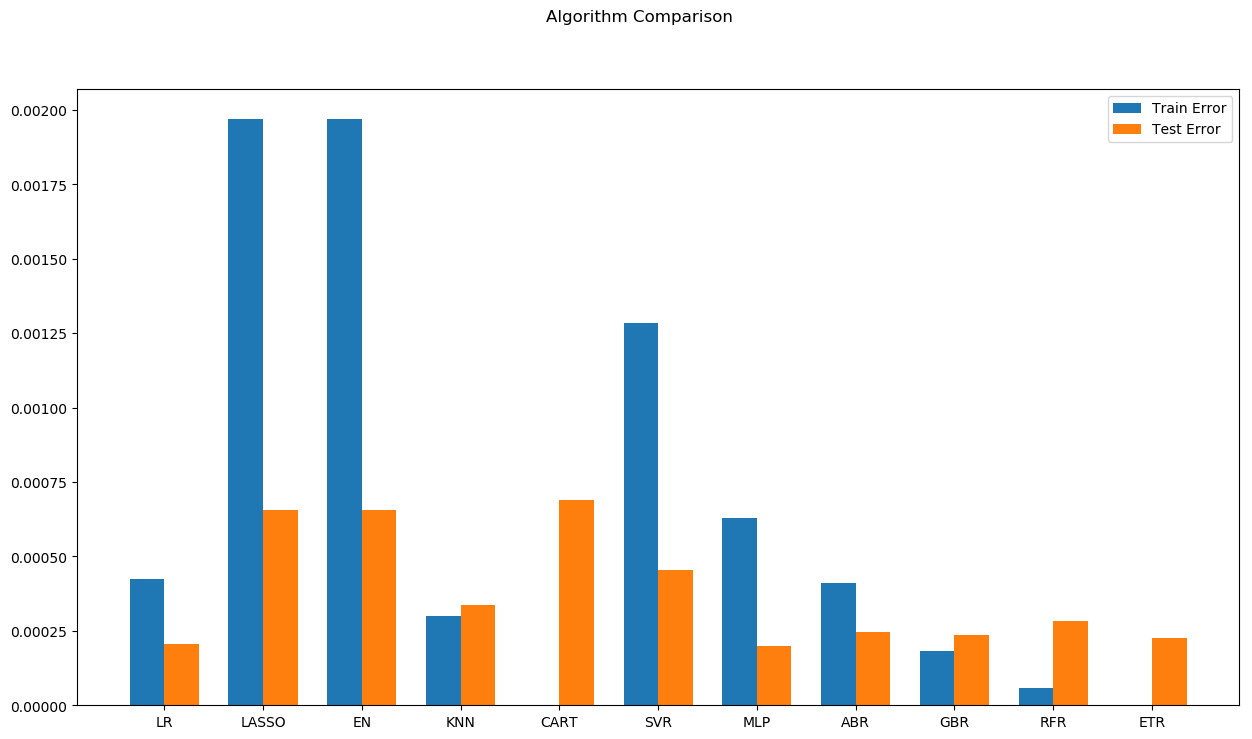

In [23]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

 We also see that the
artificial neural network (shown as MLP is the chart) algorithm shows higher errors
both in training set and test set, which is perhaps due to the linear relationship of the
variables not captured accurately by ANN or improper hyperparameters or insuffi‐
cient training of the model.

<a id='4.3.1'></a>
### 5.3.1 Time Series based models-ARIMA and LSTM

Let us first prepare the dataset for ARIMA models,
by having only the correlated varriables as exogenous variables.

### Time Series Model - ARIMA Model

In [24]:
X_train_ARIMA=X_train.loc[:, ['CES280', 'SNP', 'COSL']]
X_test_ARIMA=X_test.loc[:, ['CES280', 'SNP', 'COSL']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

错误1 NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.
statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

原因：在Python中使用了statsmodels.tsa.arima_model.ARMA或statsmodels.tsa.arima_model.ARIMA，但是这两个类在最新版本的statsmodels中已经被删除了。你应该使用statsmodels.tsa.arima.model.ARIMA或statsmodels.tsa.SARIMAX来代替它们。这两个类是基于状态空间框架的，比旧的ARMA和ARIMA类有更好的性能和功能。

参考：https://www.statsmodels.org/stable/statespace.html

In [25]:
from statsmodels.tsa.arima.model import ARIMA
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [26]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.00023173256707851165

上面这个值是什么意思呢？

下面进行模型比较


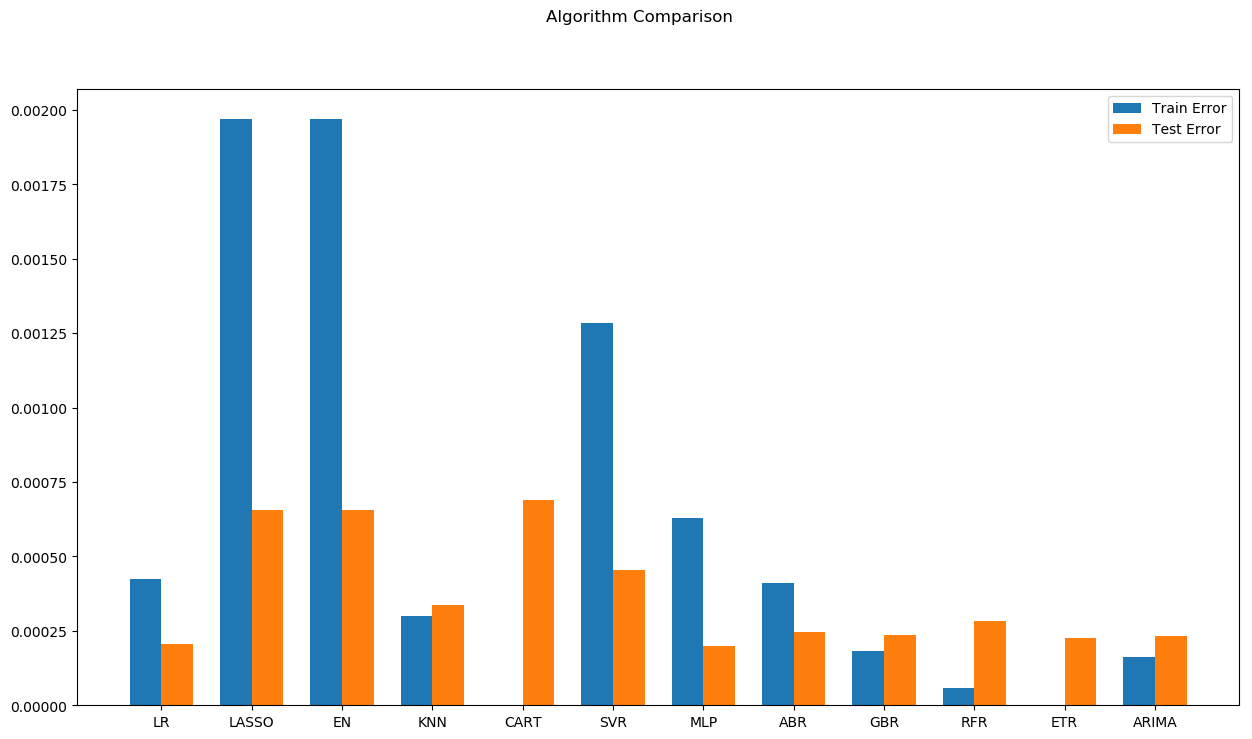

In [27]:
# add ARIMA Training and Test error into result and show it
train_results.append(error_Training_ARIMA)
test_results.append(error_Test_ARIMA)
names.append('ARIMA')

# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

ARMA确实取得不错的效果噢！

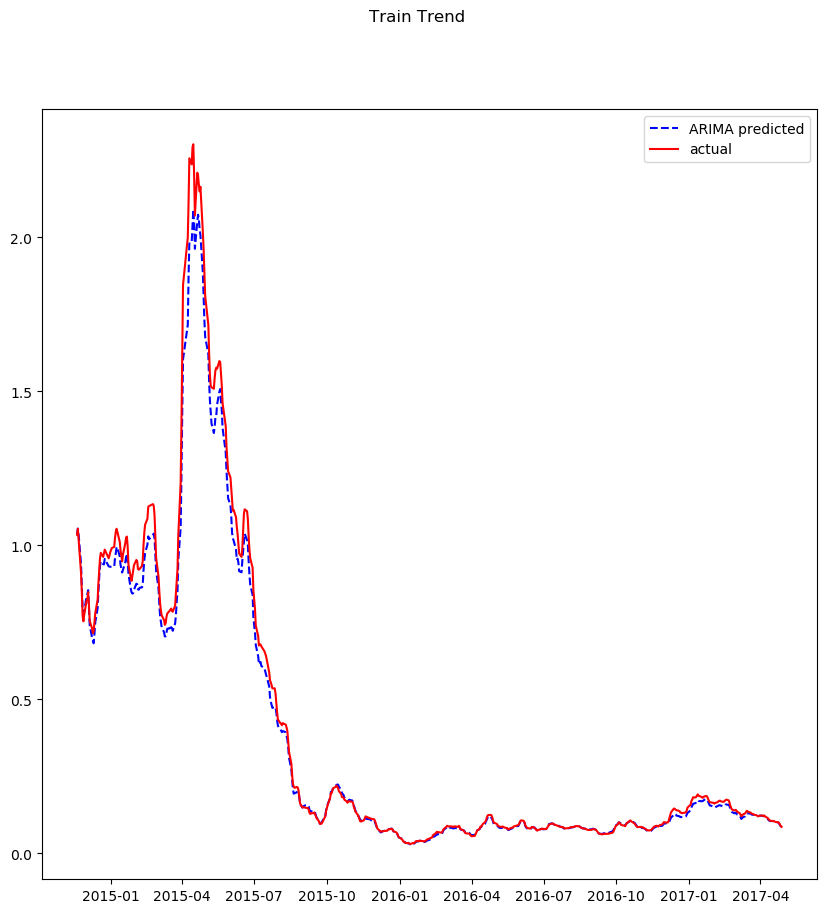

In [28]:
# Train Trend
fig = pyplot.figure(figsize=(10, 10))
fig.suptitle('Train Trend')
# predict
pyplot.plot(Y_train.index, np.exp(model_fit.fittedvalues).cumprod(), 'b--', label='ARIMA predicted')
# pyplot.plot(Y_train.index, np.exp(train_predicts[0]).cumprod(), 'g--', label='LR predicted')
pyplot.plot(Y_train.index, np.exp(Y_train['PRT_pred']).cumprod(), 'r', label='actual')
pyplot.legend()
# Y_test
pyplot.show()

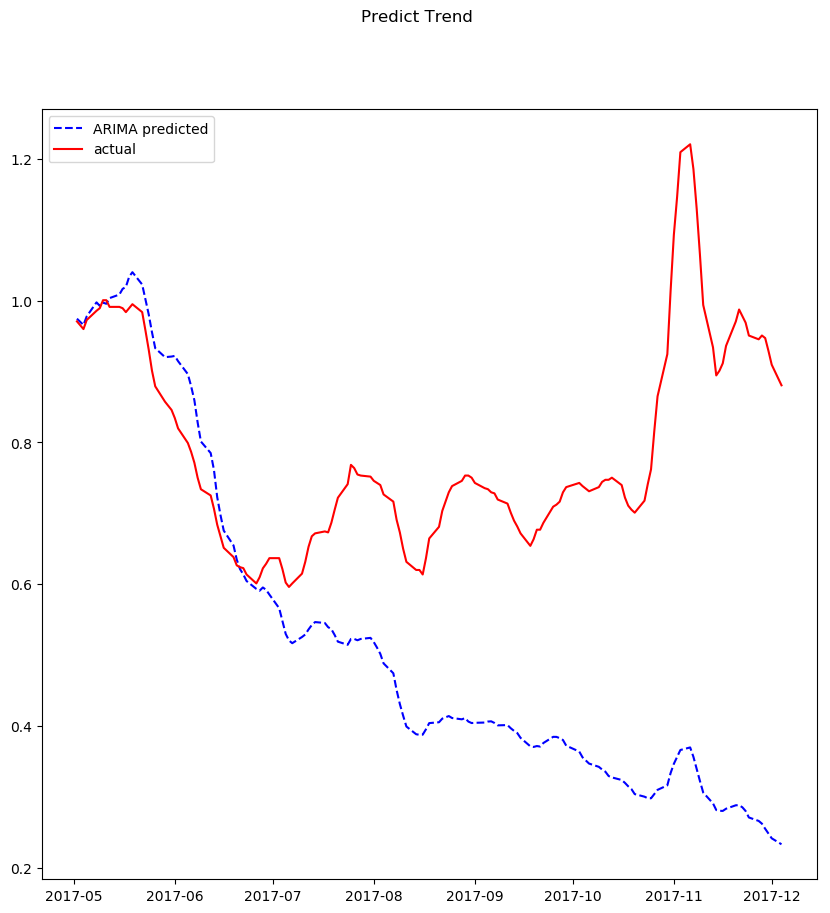

In [47]:
# predict trend
fig = pyplot.figure(figsize=(10, 10))
fig.suptitle('Predict Trend')
# predict
pyplot.plot(Y_test.index, np.exp(predicted).cumprod(), 'b--', label='ARIMA predicted')
# pyplot.plot(Y_test.index, np.exp(test_predicts[0]).cumprod(), 'g--', label='LR predicted')
pyplot.plot(Y_test.index, np.exp(Y_test['PRT_pred']).cumprod(), 'r', label='actual')
pyplot.legend()
# Y_test
pyplot.show()

###  LSTM Model

In [30]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]


In [31]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_test_LSTM, Y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


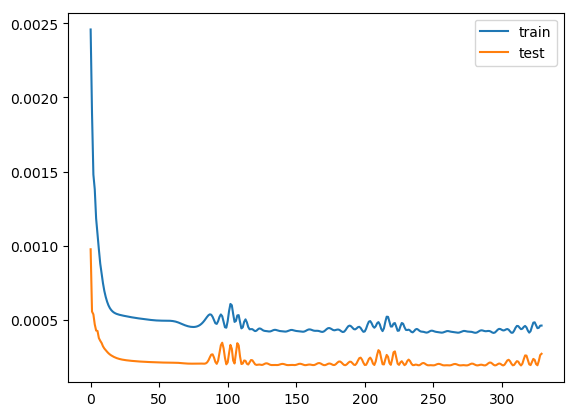

In [32]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [33]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

#### Append to previous results

In [34]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall Comparison of all the algorithms ( including Time Series Algorithms)

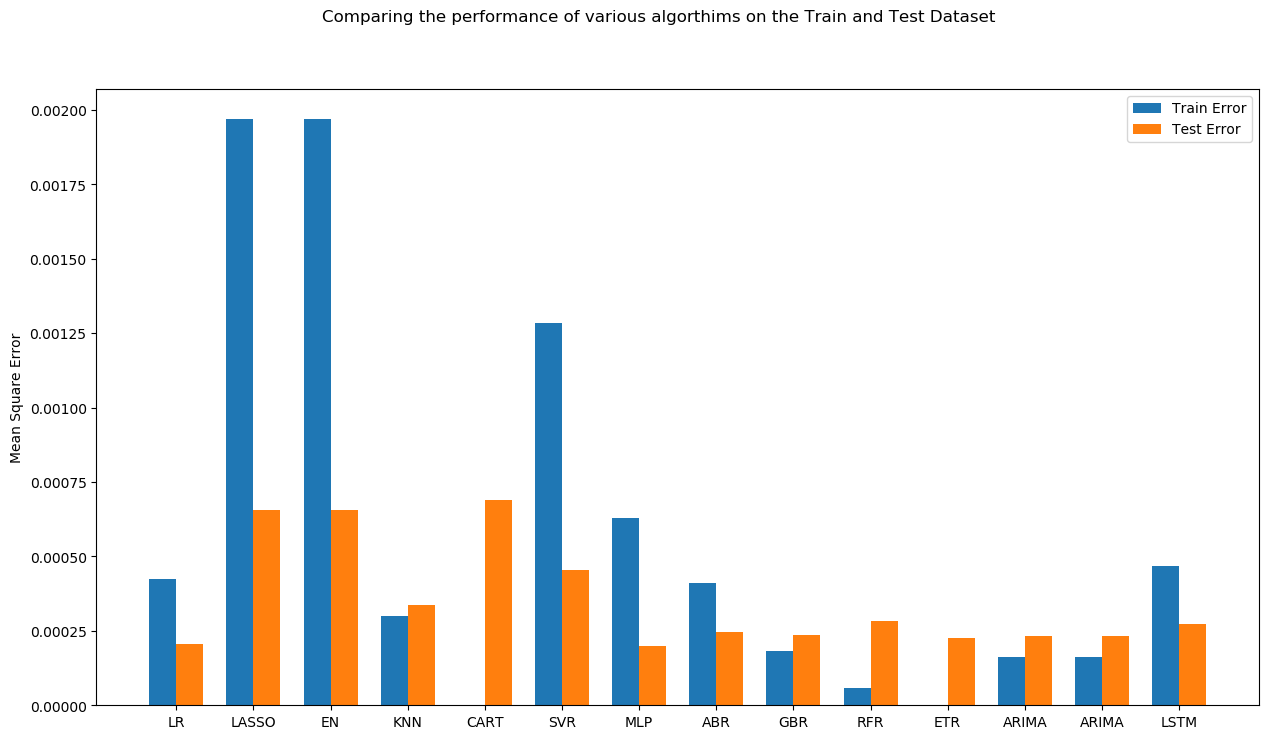

In [48]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.ylabel('Mean Square Error')
pyplot.show()

Looking at the chart above, we find time series based ARIMA model comparable to
the linear supervised-regression models such as Linear Regression (LR), Lasso Regres‐
sion (LASSO) and Elastic Net (EN). This can primarily be due to the strong linear
relationship as discussed before. The LSTM model performs decently, however,
ARIMA model outperforms the LSTM model in the test set. Hence, we select the
ARIMA model for the model tuning.

<a id='5'></a>
# 6. Model Tuning and Grid Search

As shown in the chart above the ARIMA model is one of the best mode, so we perform the model tuning of the ARIMA model. The default order of ARIMA model is [1,0,0]. We perform a grid search with different combination p,d and q in the ARIMA model's order.  

In [49]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0004296
ARIMA(0, 0, 1) MSE=0.0002509
ARIMA(0, 1, 0) MSE=0.0001789
ARIMA(0, 1, 1) MSE=0.0001788
ARIMA(1, 0, 0) MSE=0.0001617
ARIMA(1, 0, 1) MSE=0.0001609
ARIMA(1, 1, 0) MSE=0.0001788
ARIMA(1, 1, 1) MSE=0.0001777
ARIMA(2, 0, 0) MSE=0.0001606
ARIMA(2, 0, 1) MSE=0.0001616
ARIMA(2, 1, 0) MSE=0.0001786
ARIMA(2, 1, 1) MSE=0.0001744
Best ARIMA(2, 0, 0) MSE=0.0001606


In [50]:
# ARIMA model
modelARIMA1 = sm.tsa.arima.ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[2, 0, 1])
model_fit1 = modelARIMA1.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit1.fittedvalues)
predicted1 = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA, dynamic=True)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted1)
error_Test_ARIMA

0.0002366618500268549

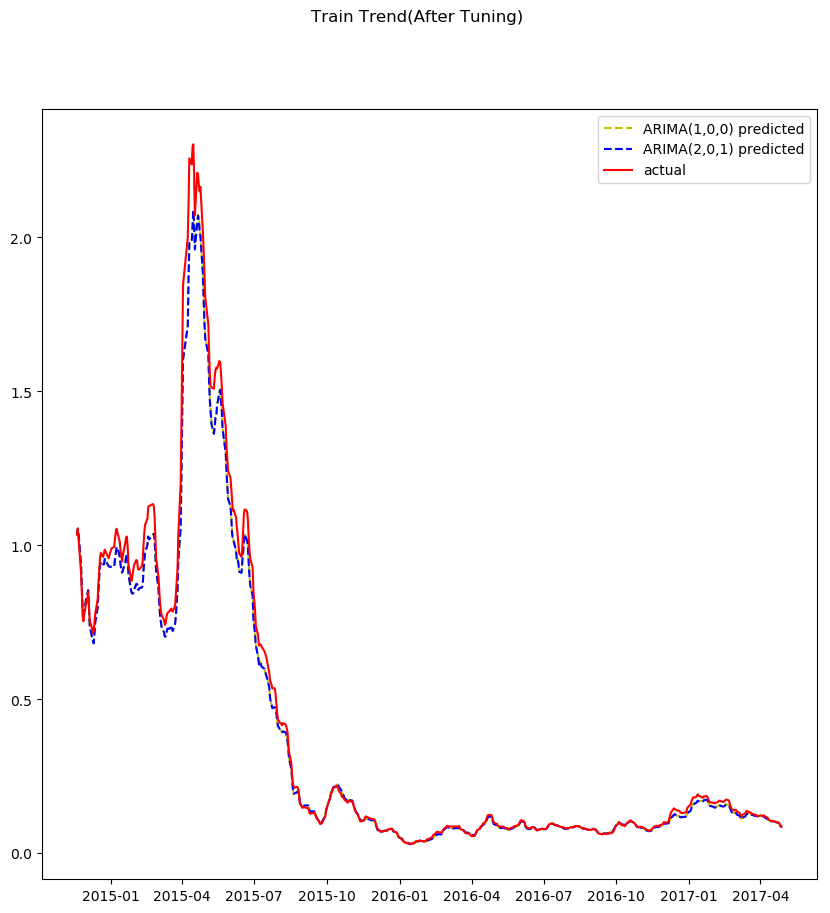

In [51]:
# Train Trend
fig = pyplot.figure(figsize=(10, 10))
fig.suptitle('Train Trend(After Tuning)')
# predict
pyplot.plot(Y_train.index, np.exp(model_fit.fittedvalues).cumprod(), 'y--', label='ARIMA(1,0,0) predicted')
pyplot.plot(Y_train.index, np.exp(model_fit1.fittedvalues).cumprod(), 'b--', label='ARIMA(2,0,1) predicted')
# pyplot.plot(Y_train.index, np.exp(train_predicts[0]).cumprod(), 'g--', label='LR predicted')
pyplot.plot(Y_train.index, np.exp(Y_train['PRT_pred']).cumprod(), 'r', label='actual')
pyplot.legend()
# Y_test
pyplot.show()

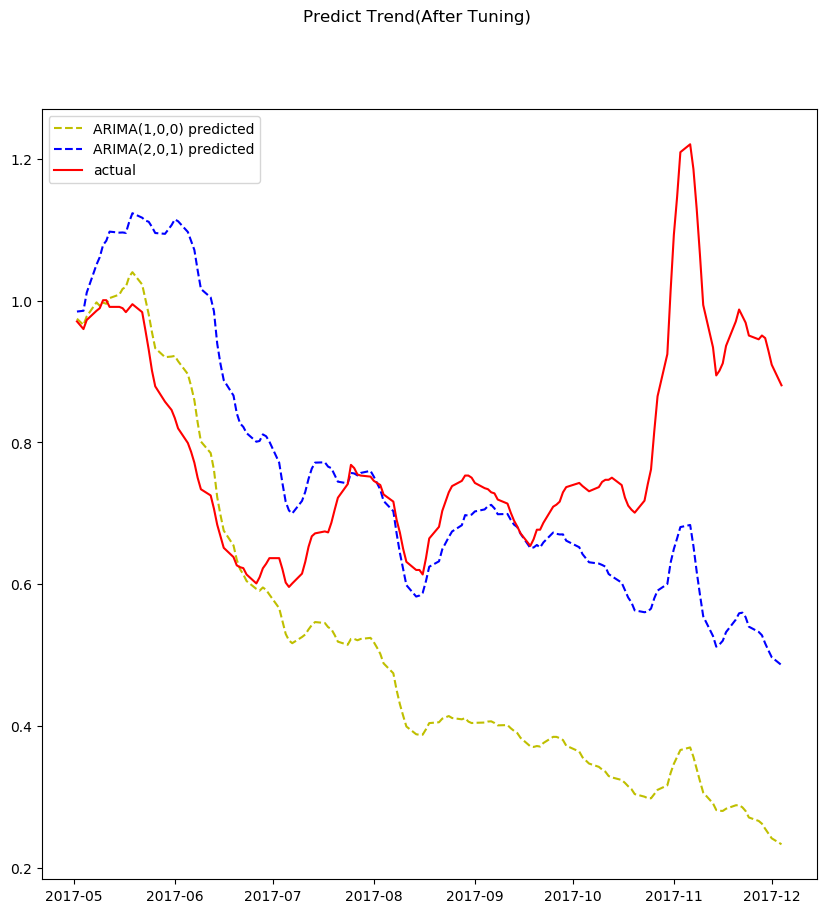

In [54]:
# predict trend
fig = pyplot.figure(figsize=(10, 10))
fig.suptitle('Predict Trend(After Tuning)')
# predict
pyplot.plot(Y_test.index, np.exp(predicted).cumprod(), 'y--', label='ARIMA(1,0,0) predicted')
pyplot.plot(Y_test.index, np.exp(predicted1).cumprod(), 'b--', label='ARIMA(2,0,1) predicted')
# pyplot.plot(Y_test.index, np.exp(test_predicts[0]).cumprod(), 'g--', label='LR predicted')
pyplot.plot(Y_test.index, np.exp(Y_test['PRT_pred']).cumprod(), 'r', label='actual')
pyplot.legend()
# Y_test
pyplot.show()

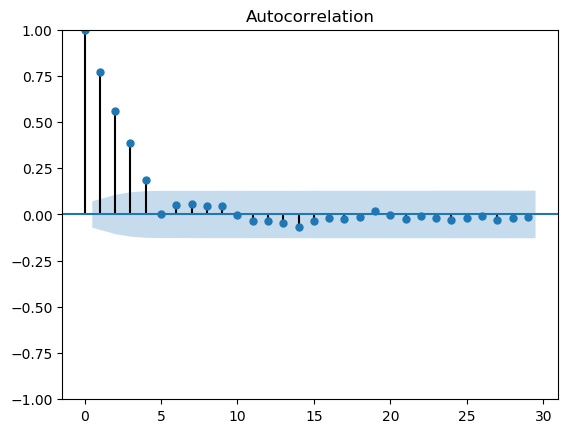

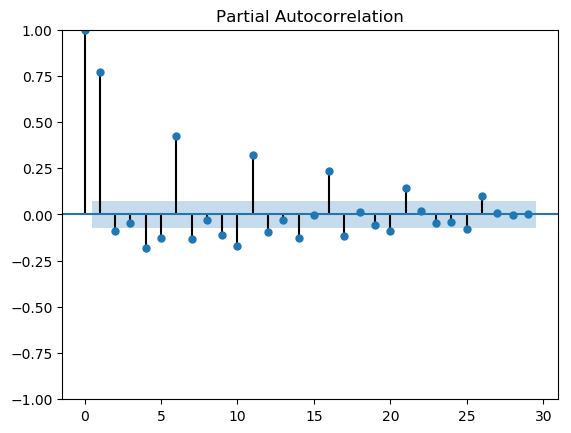

In [40]:
# plot autocorrelation function and partial correlation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

output_plt1 = plot_acf(Y)
output_plt2 = plot_pacf(Y)

In [41]:
# ARIMA model
modelARIMA2 = sm.tsa.arima.ARIMA(endog=Y_train, exog=X_train_ARIMA, order=[3, 0, 1])
model_fit2 = modelARIMA2.fit()

error_Training_ARIMA = mean_squared_error(Y_train, model_fit2.fittedvalues)
predicted2 = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA, dynamic=True)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted1)
error_Test_ARIMA

0.0002366618500268549

<a id='6'></a>
# 7. Finalise the Model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [42]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [43]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.00023173256707851165


After tuning the model and picking the best ARIMA model or the order 2,0 and 1 we select this model and can it can be used for the modeling purpose. 

<a id='6.2'></a>
## 7.2. Save Model for Later Use

In [44]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model_fit_tuned, open(filename, 'wb'))

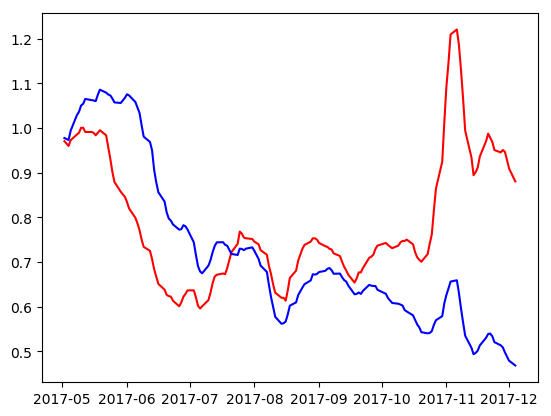

In [56]:
# Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
pyplot.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
pyplot.plot(np.exp(predicted_tuned).cumprod(), 'b')
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

### Summary

We can conclude that simple models - linear regression, regularized regression (i.e.
Lasso and elastic net) - along with the time series model such as ARIMA are promis‐
ing modelling approaches for asset price prediction problem. These models can
enable financial practitioners to model time dependencies with a very flexible
approach. The overall approach presented in this case study may help us encounter
overfitting and underfitting which are some of the key challenges in the prediction
problem in finance.
We should also note that we can use better set of indicators, such as P/E ratio, trading
volume, technical indicators or news data, which might lead to better results. We will
demonstrate this in some of the case studies in the book.
Overall, we created a supervised-regression and time series modelling framework
which allows us to perform asset class prediction using historical data to generate
results and analyze risk and profitability before risking any actual capital.